We need to generate three graphs: 
- Histogram of Number of `loc_min` points were found, (so outputs of the Optim routine) and what percentage of them is within a small distance of a critical point of the approximant. As a function of the degree `d` of the approximant.


In [38]:
using Pkg
using Revise
Pkg.activate("../../.")
using Globtim
using DynamicPolynomials, DataFrames
using ProgressLogging
using Optim
using CairoMakie
using LinearAlgebra
using CSV  # Add CSV here for loading reference data
CairoMakie.activate!()

  Activating project at `~/globtim`


In [39]:
d_min, d_max = 2, 10  # Using max degree 4 for testing

(2, 10)

In [40]:
# Using the legacy approach with load_function_params
# Deuflhard_4d is already defined in Globtim
params = load_function_params("Deuflhard_4d")
TR = test_input(Deuflhard_4d;
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=params.tolerance)

@polyvar(x[1:TR.dim]); # Define polynomial ring

In [41]:
# Load the pre-computed 4D critical points from the orthant analysis
df_orthant_critical = CSV.read("../ForwardDiff_Certification/by_degree/data/4d_all_critical_points_orthant.csv", DataFrame)

# Extract just the coordinates and function values
df_reference_points = DataFrame(
    x1 = df_orthant_critical.x1,
    x2 = df_orthant_critical.x2, 
    x3 = df_orthant_critical.x3,
    x4 = df_orthant_critical.x4,
    z = df_orthant_critical.function_value
)

println("Loaded $(nrow(df_reference_points)) reference critical points from orthant analysis")

Loaded 25 reference critical points from orthant analysis


In [42]:
display(df_reference_points)

Row,x1,x2,x3,x4,z
,Float64,Float64,Float64,Float64,Float64
1,0.256625,-1.01625,0.256625,-1.01625,4.9235e-27
2,0.256625,-1.01625,0.507031,-0.917351,0.283545
3,0.256625,-1.01625,0.741152,-0.741152,3.23705e-27
4,0.256625,-1.01625,0.917351,-0.507031,0.283545
5,0.256625,-1.01625,1.01625,-0.256625,5.51504e-27
6,0.507031,-0.917351,0.256625,-1.01625,0.283545
7,0.507031,-0.917351,0.507031,-0.917351,0.56709
8,0.507031,-0.917351,0.741152,-0.741152,0.283545
9,0.507031,-0.917351,0.917351,-0.507031,0.56709


In [43]:
# Analyze polynomial approximations for different degrees
results = Dict{Int,Any}()

# Make sure we have reference points loaded
if !@isdefined(df_reference_points)
    error("Please run the cell that loads df_reference_points first!")
end

for d in d_min:d_max
    println("Analyzing degree $d...")
    
    # Construct polynomial for this degree
    pol = Constructor(TR, d, basis=:chebyshev, verbose=false)
    
    # Extract actual degree (handle both Int and Tuple cases)
    actual_degree = pol.degree isa Tuple ? pol.degree[2] : pol.degree
    
    # Solve polynomial system
    solutions = solve_polynomial_system(x, 4, actual_degree, pol.coeffs, basis=:chebyshev)
    
    # Process critical points
    df_crit = process_crit_pts(solutions, Deuflhard_4d, TR)
    
    # Apply BFGS refinement to critical points
    refined_points = []
    captured_flags = Bool[]
    
    for i in 1:nrow(df_crit)
        pt = [df_crit[i, Symbol("x$j")] for j in 1:4]
        res = Optim.optimize(Deuflhard_4d, pt, BFGS(), 
                           Optim.Options(g_tol=1e-8, f_abstol=1e-20, x_abstol=1e-12))
        
        refined_pt = Optim.minimizer(res)
        push!(refined_points, refined_pt)
        
        # Check if point is captured by comparing to reference critical points
        min_dist_to_ref = Inf
        for j in 1:nrow(df_reference_points)
            ref_pt = [df_reference_points[j, Symbol("x$k")] for k in 1:4]
            dist = norm(refined_pt - ref_pt)
            min_dist_to_ref = min(min_dist_to_ref, dist)
        end
        
        # Point is captured if it's close to a reference critical point
        push!(captured_flags, min_dist_to_ref < 0.001)  # Using tolerance of 0.001
    end
    
    # Create dataframe with refined points
    df_min = DataFrame()
    for j in 1:4
        df_min[!, Symbol("x$j")] = [p[j] for p in refined_points]
    end
    df_min[!, :z] = [Deuflhard_4d(p) for p in refined_points]
    df_min[!, :captured] = captured_flags
    
    # Store results in format expected by notebook functions
    results[d] = (
        df = df_crit,        # Critical points from polynomial
        df_min = df_min,     # Refined points with captured flag
        convergence_stats = (nrm = pol.nrm,),
        discrete_l2 = pol.nrm
    )
    
    println("  Found $(nrow(df_crit)) critical points, $(sum(captured_flags)) captured (using orthant reference)")
end

Analyzing degree 2...
current L2-norm: 25.801935970928422
  Found 1 critical points, 1 captured (using orthant reference)
Analyzing degree 3...
current L2-norm: 16.21499798232247
  Found 4 critical points, 4 captured (using orthant reference)
Analyzing degree 4...
current L2-norm: 8.239501991634233
  Found 25 critical points, 25 captured (using orthant reference)
Analyzing degree 5...
current L2-norm: 3.7330498115158988
  Found 16 critical points, 16 captured (using orthant reference)
Analyzing degree 6...
current L2-norm: 1.4932719791613223
  Found 25 critical points, 4 captured (using orthant reference)
Analyzing degree 7...
current L2-norm: 0.6631175079244837
Tracking 1296 paths...  77%|█████████████████████▋      |  ETA: 0:00:00



Tracking 1296 paths... 100%|████████████████████████████| Time: 0:00:00
                   # paths tracked: 1296
   # non-singular solutions (real): 1216 (144)
       # singular endpoints (real): 80 (0)
          # total solutions (real): 1296 (144)
  Fo

In [44]:
# Access the extension module directly
const GlobtimExt = Base.get_extension(Globtim, :GlobtimCairoMakieExt)
const plot_discrete_l2 = GlobtimExt.plot_discrete_l2
const capture_histogram = GlobtimExt.capture_histogram
const plot_convergence_analysis = GlobtimExt.plot_convergence_analysis

plot_convergence_analysis (generic function with 1 method)

In [45]:
# Compute the tensored 4d dataframe and load CSV data
using IterTools
using CSV

function double_dataframe(df::DataFrame)
    n = nrow(df)
    pairs = collect(product(1:n, 1:n))

    x1 = vec([df.x[j[1]] for j in pairs])
    y1 = vec([df.y[j[1]] for j in pairs])
    x2 = vec([df.x[j[2]] for j in pairs])
    y2 = vec([df.y[j[2]] for j in pairs])

    return DataFrame(x1=x1, x2=y1, x3=x2, x4=y2)
end

df_chebfun = CSV.read("../../data/matlab_critical_points/valid_points_deuflhard.csv", DataFrame)
df_4d = double_dataframe(df_chebfun);

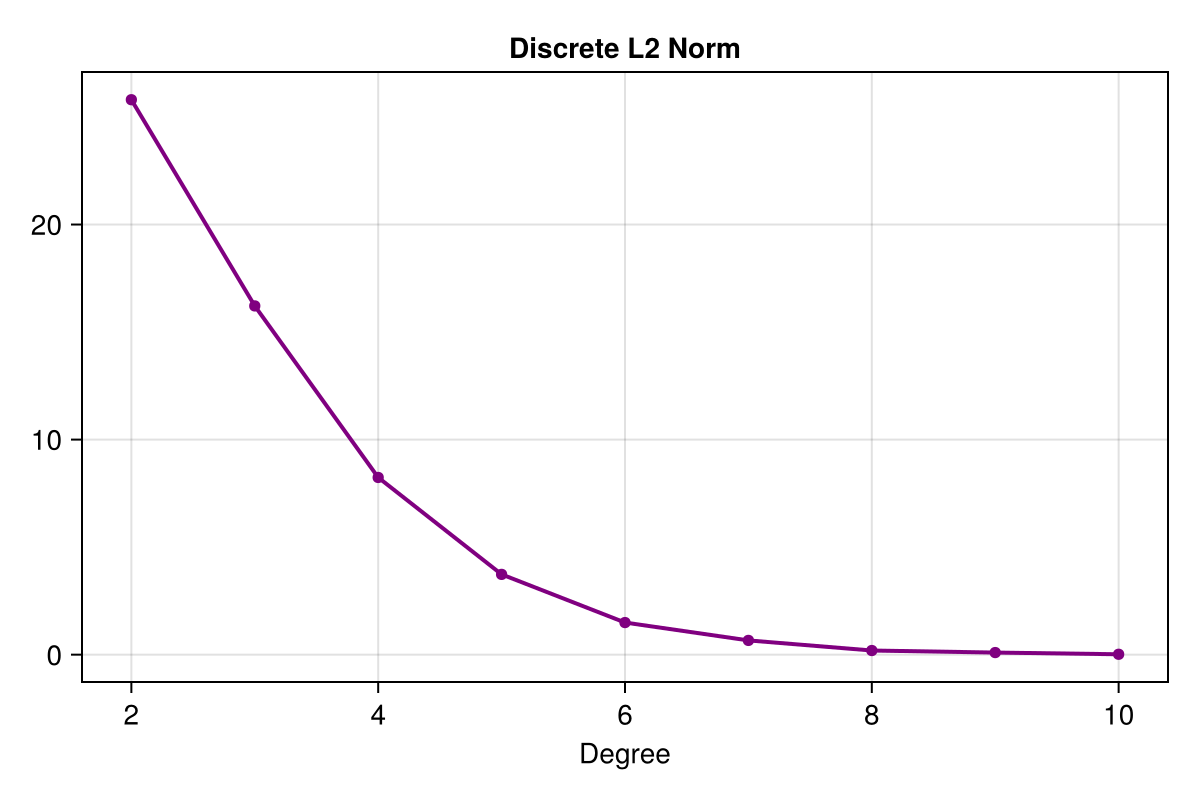

CairoMakie.Screen{IMAGE}


In [57]:
fig_1 = plot_discrete_l2(results, d_min, d_max, 1)
save("discrete_l2.pdf", fig_1)
display(fig_1)

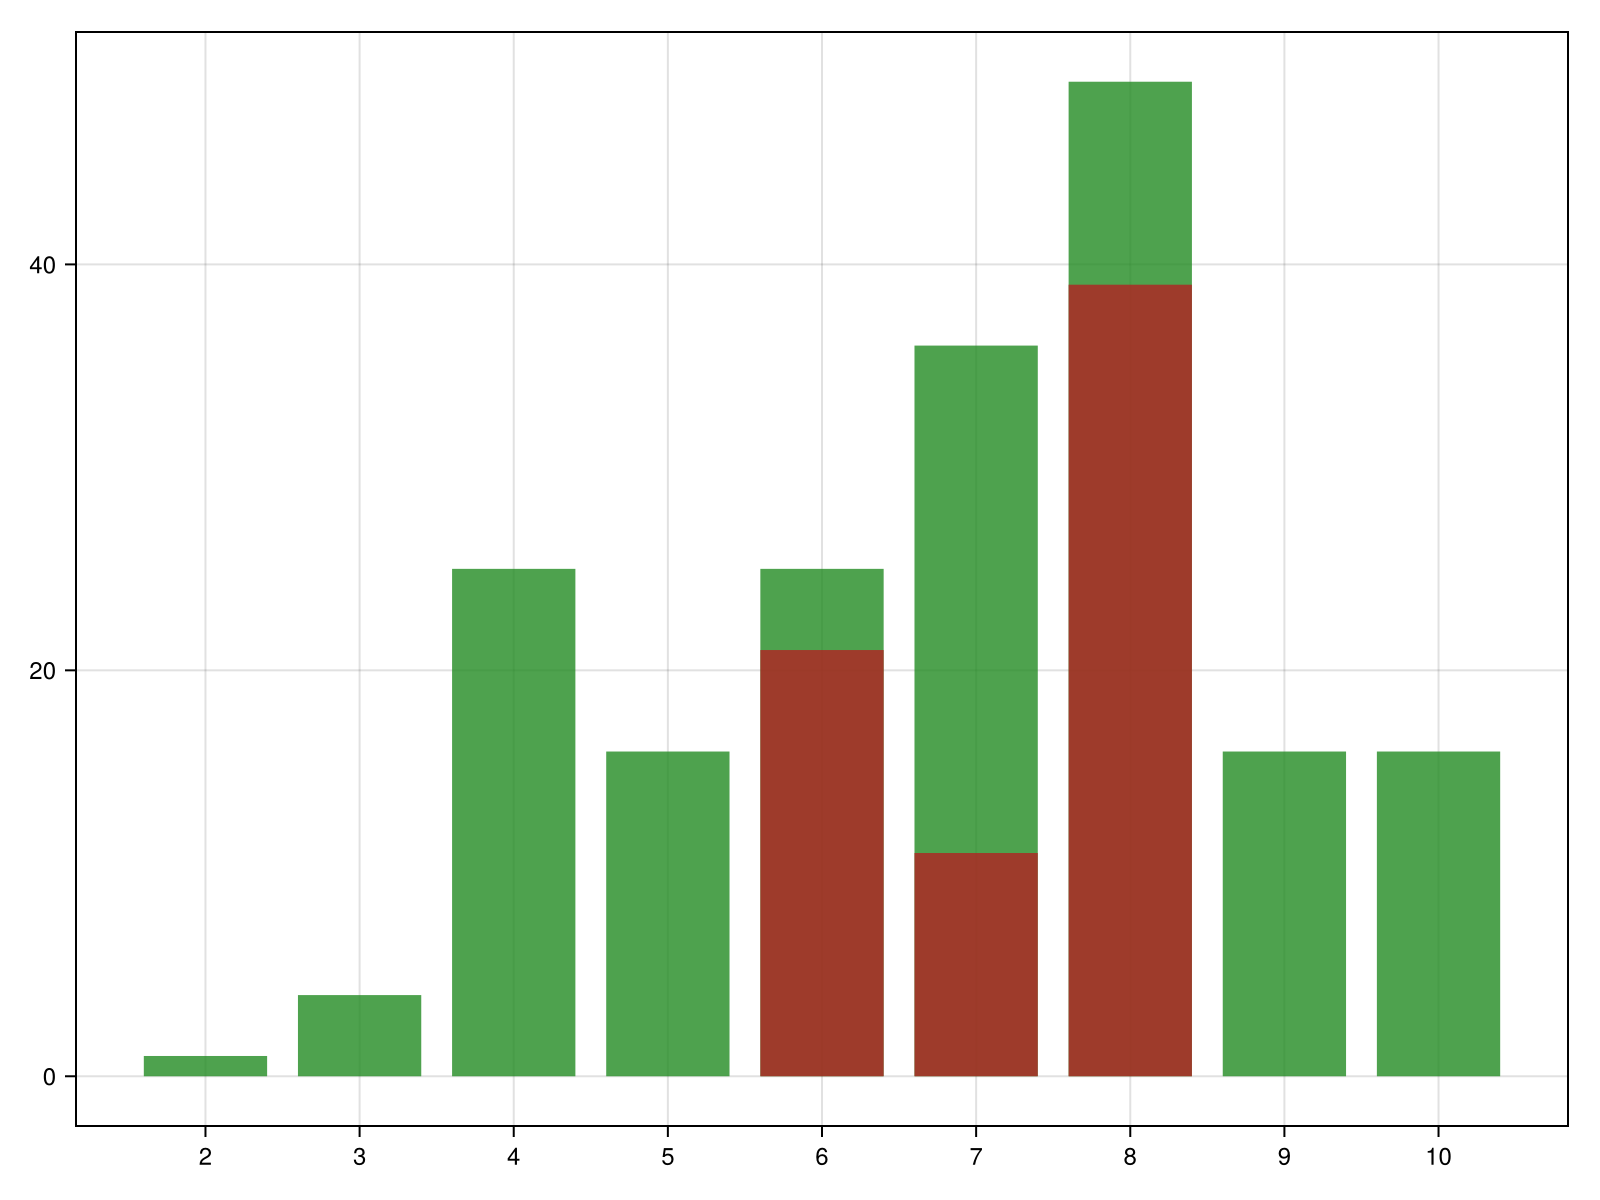

CairoMakie.Screen{IMAGE}


In [46]:
fig_2 = capture_histogram(results, d_min, d_max, 1, tol_dist=.1, show_legend=false)
save("histogram.pdf", fig_2)
display(fig_2)

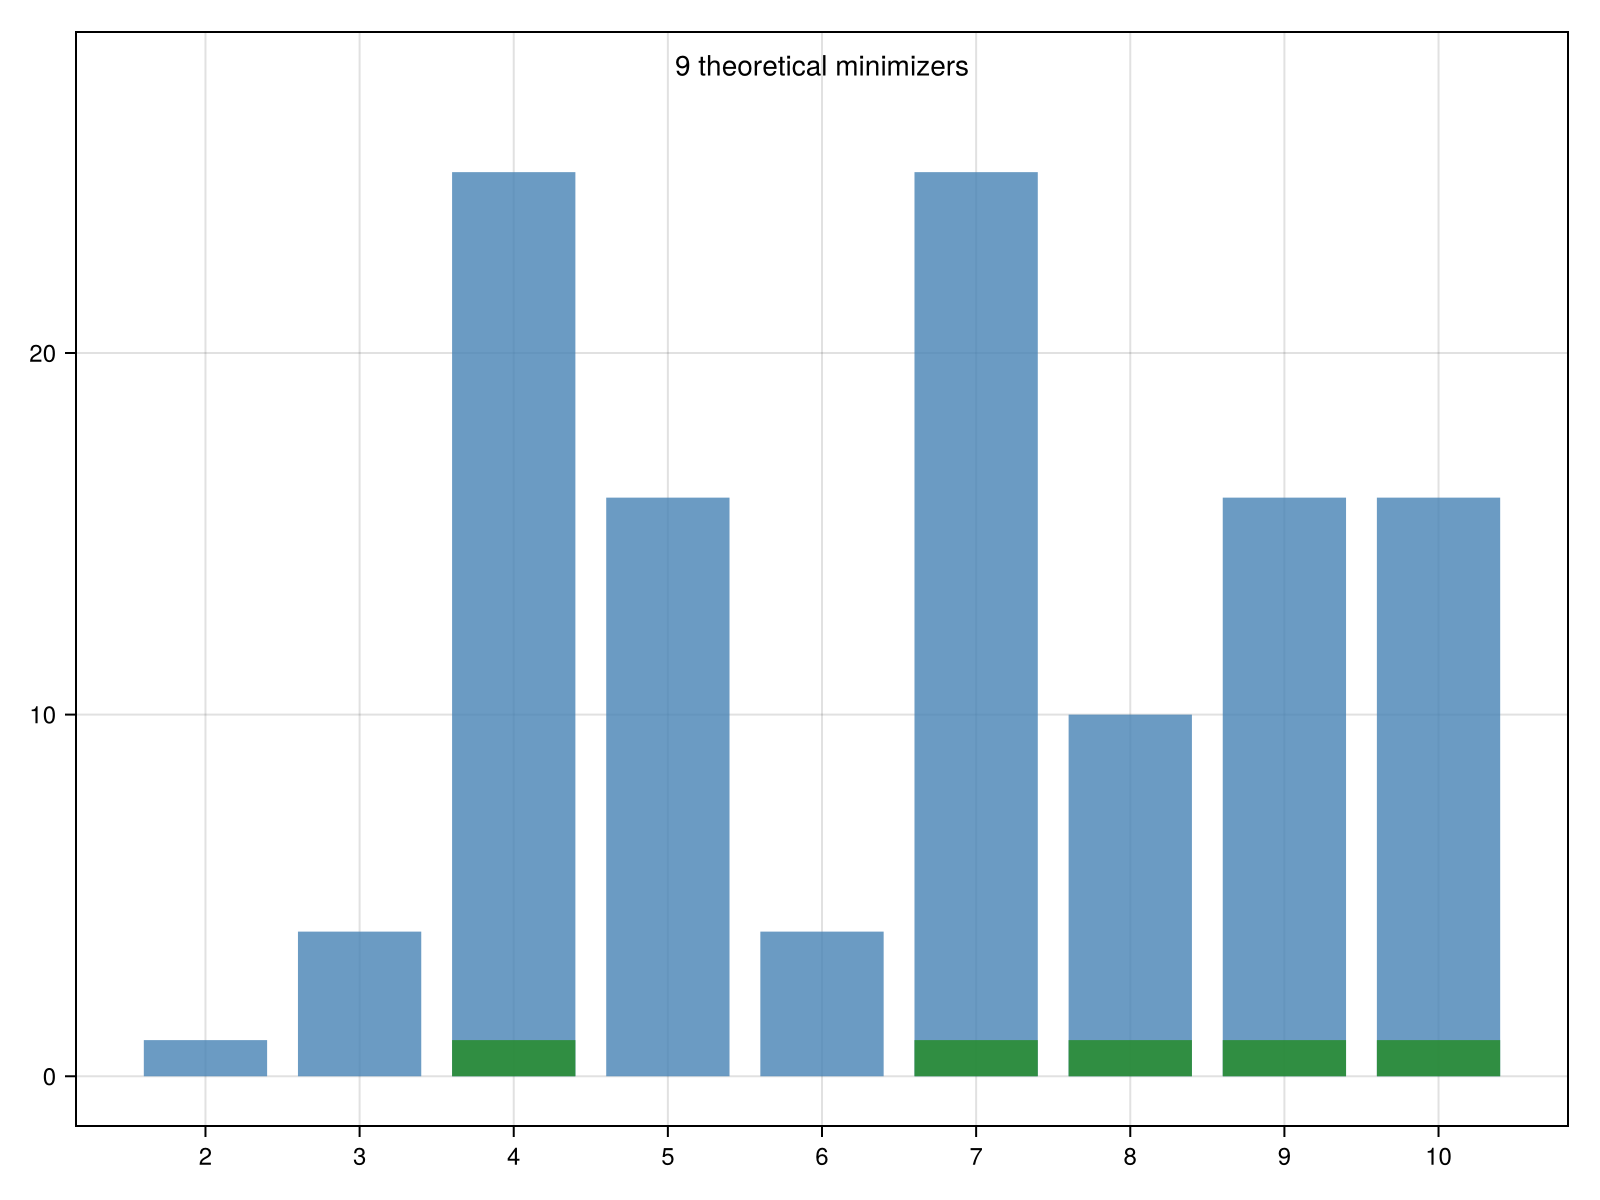

CairoMakie.Screen{IMAGE}


In [47]:
# Add histogram_enhanced to the imported functions
const histogram_enhanced = GlobtimExt.histogram_enhanced

# Create enhanced histogram using orthant critical points
fig_enhanced = histogram_enhanced(
    results, 
    df_orthant_critical,  # Full theoretical critical points data
    d_min, 
    d_max, 
    1,
    tol_bfgs = 0.001,    # Tolerance for BFGS convergence
    tol_raw = 0.1,       # Tolerance for raw points  
    show_legend = true
)
save("histogram_enhanced.pdf", fig_enhanced)
display(fig_enhanced)

### Histogram Comparison

The **original histogram** (above) shows captured vs uncaptured based on whether BFGS refinement moved the point by less than 0.1.

The **enhanced histogram** (above) specifically tracks convergence to the 9 theoretical minimizers:
- **Blue bars**: BFGS points that converged to theoretical minimizers (tolerance = 0.001)  
- **Green bars**: Raw polynomial critical points already close to theoretical minimizers (tolerance = 0.1)

This enhanced view shows:
1. How many of the polynomial's critical points actually lead to true minima after refinement
2. How many raw critical points are already good approximations of minima (green)
3. The polynomial degree needed to capture all 9 theoretical minimizers

In [48]:
# Define helper function expected by plot_convergence_analysis
function analyze_convergence_distances(df::DataFrame)
    # For each critical point, compute distance to nearest other critical point
    n_points = nrow(df)
    x_cols = [col for col in names(df) if startswith(string(col), "x")]
    n_dims = length(x_cols)
    
    min_distances = Float64[]
    
    for i in 1:n_points
        point1 = [df[i, Symbol("x$j")] for j in 1:n_dims]
        min_dist = Inf
        
        for j in 1:n_points
            if i != j
                point2 = [df[j, Symbol("x$j")] for j in 1:n_dims]
                dist = norm(point1 - point2)
                min_dist = min(min_dist, dist)
            end
        end
        
        if isfinite(min_dist)
            push!(min_distances, min_dist)
        end
    end
    
    if isempty(min_distances)
        return (maximum=0.0, average=0.0)
    end
    
    return (
        maximum=maximum(min_distances),
        average=sum(min_distances) / length(min_distances)
    )
end

analyze_convergence_distances (generic function with 1 method)

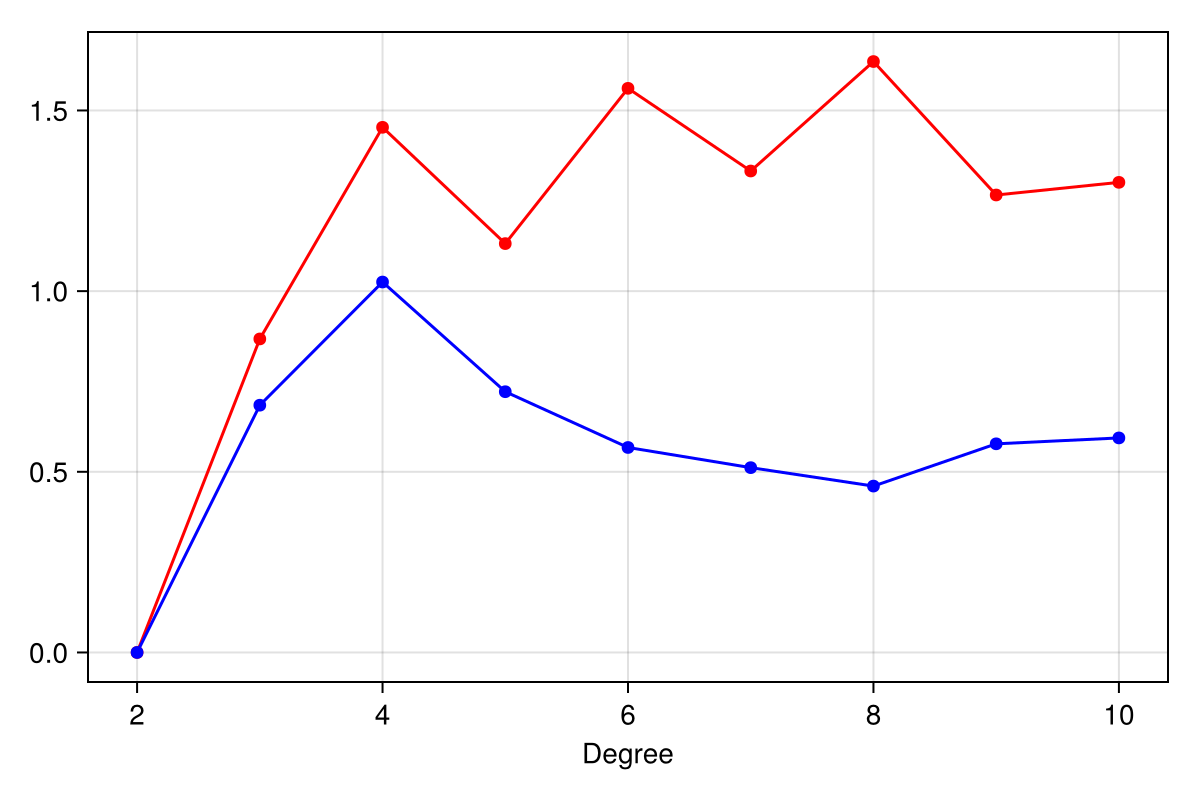

CairoMakie.Screen{IMAGE}


In [60]:
fig_3 = plot_convergence_analysis(results, d_min, d_max, 1, show_legend=true)
# save("convergence_analysis.pdf", fig_3)
display(fig_3)

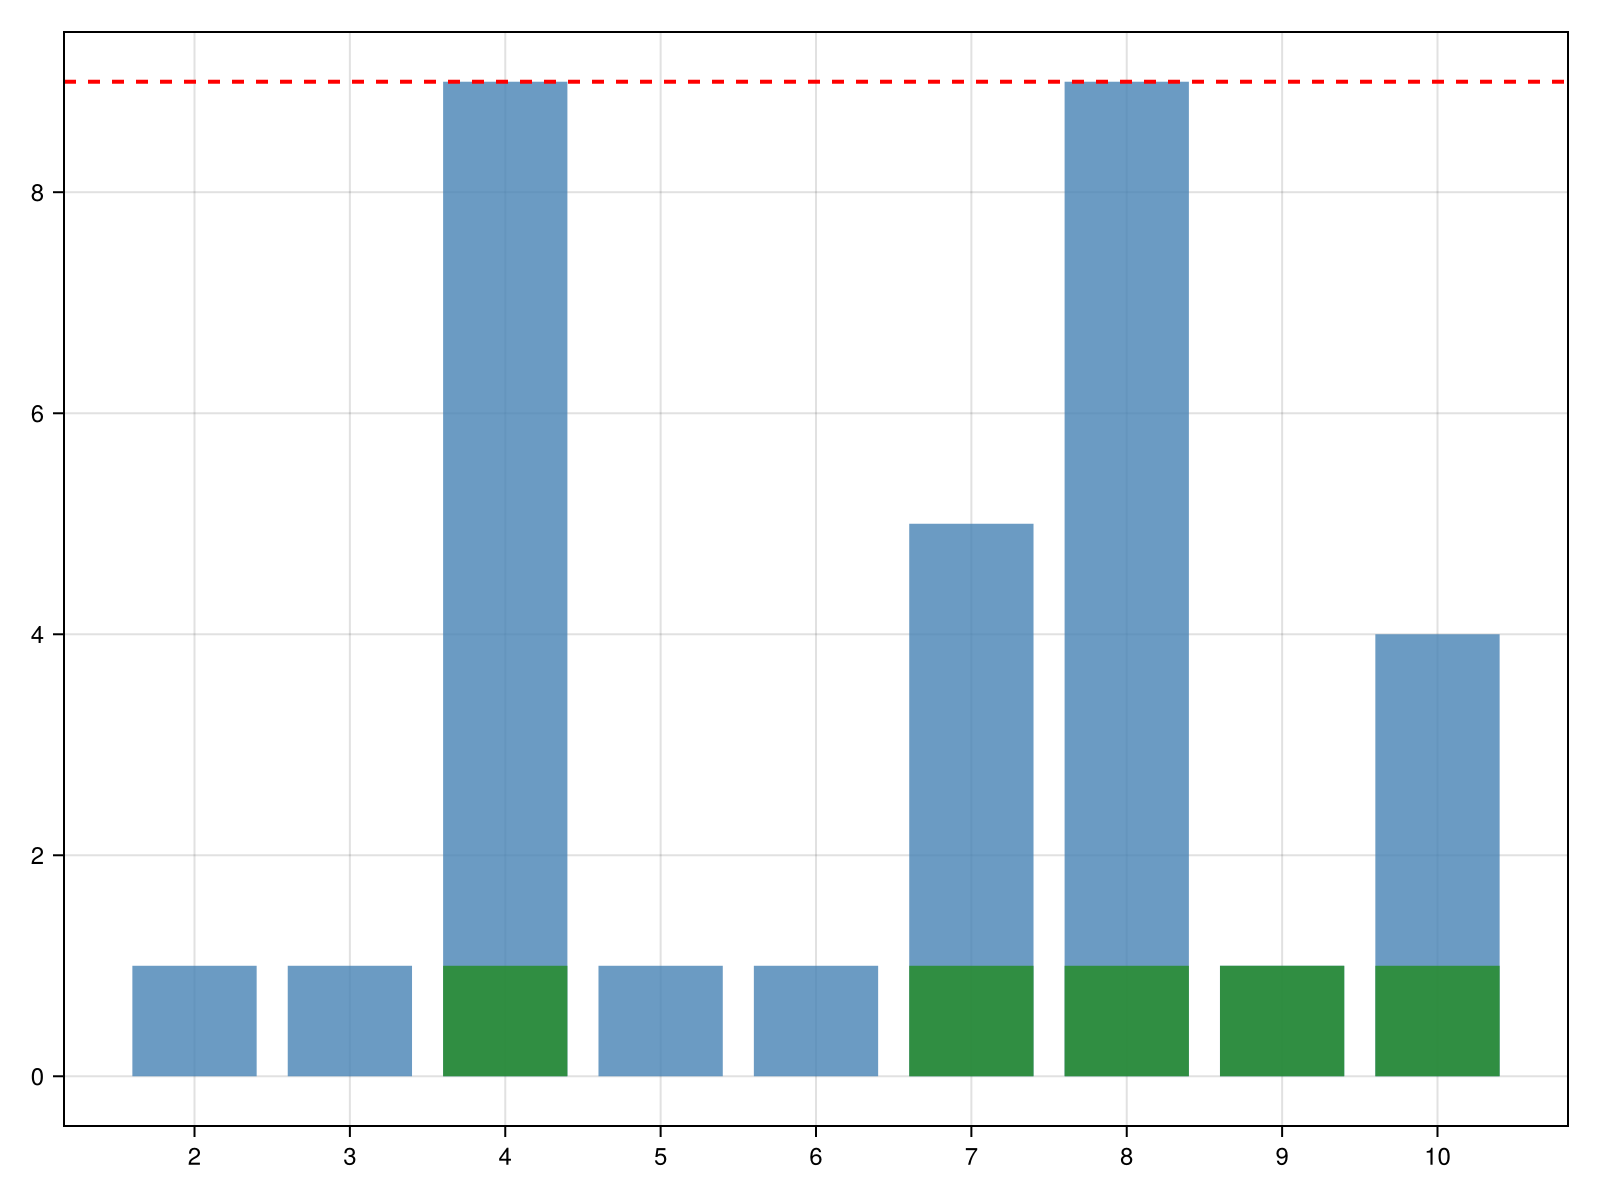

CairoMakie.Screen{IMAGE}


In [50]:
# Add histogram_minimizers_only to the imported functions
const histogram_minimizers_only = GlobtimExt.histogram_minimizers_only

# Create minimizers-only histogram
fig_minima = histogram_minimizers_only(
    results, 
    df_orthant_critical,
    d_min, 
    d_max, 
    1,
    tol_theoretical = 0.001,   # Tolerance for matching theoretical points
    show_legend = false
)
save("histogram_minima_only.pdf", fig_minima)
display(fig_minima)

### Minimizers-Only Histogram

This histogram focuses exclusively on **minimum points** (where f < 1e-6), filtering out saddle points and maxima:

- **Blue bars**: BFGS refined points that are minima (low function value)
- **Green bars**: Raw polynomial critical points that are already minima  
- **Dark blue bars**: BFGS minima that match theoretical minimizers
- **Red dashed line**: The 9 theoretical minimizers we're trying to find

This view shows:
1. Not all polynomial critical points are minima (compare total points vs minima)
2. Some raw polynomial points are already good minima approximations (green)
3. Progress toward finding all 9 theoretical minimizers as degree increases

In [51]:
# Define helper functions
function compute_min_distances(df, df_check)
    # Initialize array to store minimum distances
    min_distances = Float64[]

    # For each row in df, find distance to closest point in df_check
    for i in 1:nrow(df)
        point = [df[i, Symbol("x$j")] for j in 1:4]  # Extract point coordinates
        min_dist = Inf

        # Compare with each point in df_check
        for j in 1:nrow(df_check)
            check_point = [df_check[j, Symbol("x$j")] for j in 1:4]
            dist = norm(point - check_point)  # Euclidean distance
            min_dist = min(min_dist, dist)
        end

        push!(min_distances, min_dist)
    end

    return min_distances
end

function analyze_captured_distances(df, df_check)
    distances = compute_min_distances(df, df_check)
    return (
        maximum=maximum(distances),
        average=sum(distances) / length(distances)
    )
end

analyze_captured_distances (generic function with 1 method)

In [52]:
# Define the plot_convergence_captured function
function plot_convergence_captured(results, df_check, start_degree::Int, end_degree::Int, step::Int; show_legend::Bool=true)
    degrees = start_degree:step:end_degree
    max_distances = Float64[]
    avg_distances = Float64[]

    for d in degrees
        x_cols = [col for col in names(results[d].df_min) if startswith(string(col), "x")]
        df = results[d].df_min[:, x_cols]

        stats = analyze_captured_distances(df, df_check)
        push!(max_distances, stats.maximum)
        push!(avg_distances, stats.average)
    end

    fig = Figure(size=(600, 400))

    ax = Axis(fig[1, 1],
        # xlabel removed per user request
        # ylabel removed per user request
        )

    scatterlines!(ax, degrees, max_distances, label="Maximum", color=:red)
    scatterlines!(ax, degrees, avg_distances, label="Average", color=:blue)

    # Legend removed per user request - respect show_legend parameter
    # if show_legend
    #     axislegend(ax)
    # end

    return fig
end

plot_convergence_captured (generic function with 1 method)

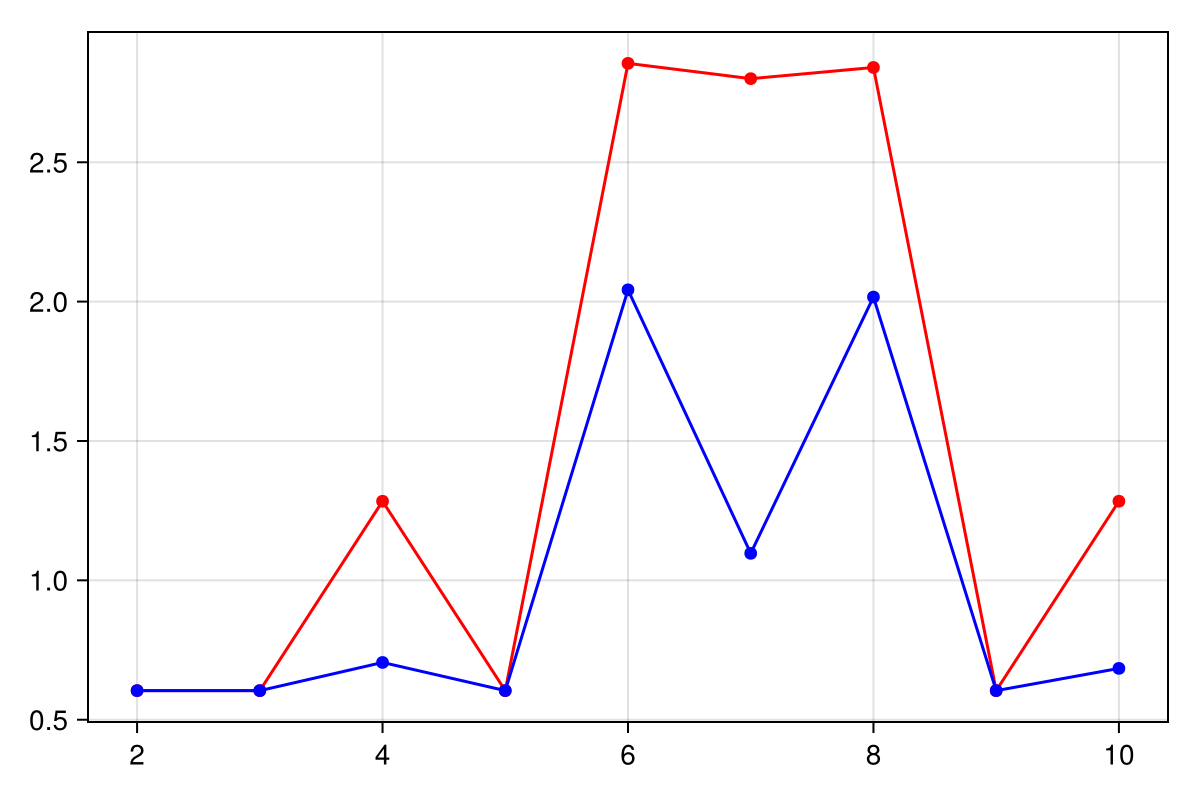

CairoMakie.Screen{IMAGE}


In [53]:
using LinearAlgebra
# Use the reference critical points from orthant analysis instead of df_4d
fig_4 = plot_convergence_captured(results, df_reference_points, d_min, d_max, 1, show_legend=false)
save("convergence_captured_orthant.pdf", fig_4)
display(fig_4)

In [54]:
# Summary of capture rates with orthant reference points
println("\n=== Capture Rate Summary (using orthant reference points) ===")
println("Degree | Total Points | Captured | Uncaptured | Capture Rate")
println("-------|--------------|----------|------------|-------------")
for d in d_min:d_max
    total = nrow(results[d].df_min)
    captured = sum(results[d].df_min.captured)
    uncaptured = total - captured
    rate = captured / total * 100
    println("   $d   |      $(lpad(total, 3))     |    $(lpad(captured, 3))   |     $(lpad(uncaptured, 3))    |   $(round(rate, digits=1))%")
end

println("\nNote: Points are considered 'captured' if they are within 0.001 distance")
println("of any reference critical point from the orthant analysis.")


=== Capture Rate Summary (using orthant reference points) ===
Degree | Total Points | Captured | Uncaptured | Capture Rate
-------|--------------|----------|------------|-------------
   2   |        1     |      1   |       0    |   100.0%
   3   |        4     |      4   |       0    |   100.0%
   4   |       25     |     25   |       0    |   100.0%
   5   |       16     |     16   |       0    |   100.0%
   6   |       25     |      4   |      21    |   16.0%
   7   |       36     |     25   |      11    |   69.4%
   8   |       49     |     10   |      39    |   20.4%
   9   |       16     |     16   |       0    |   100.0%
   10   |       16     |     16   |       0    |   100.0%

Note: Points are considered 'captured' if they are within 0.001 distance
of any reference critical point from the orthant analysis.


In [55]:
# Analyze which reference points are being found
println("\n=== Reference Point Coverage Analysis ===")
println("Checking which of the $(nrow(df_reference_points)) reference points are found by degree 8...")

# For degree 8, check which reference points are matched
d8_refined = results[8].df_min
ref_found = falses(nrow(df_reference_points))

for i in 1:nrow(df_reference_points)
    ref_pt = [df_reference_points[i, Symbol("x$j")] for j in 1:4]
    
    # Check if any refined point is close to this reference point
    for j in 1:nrow(d8_refined)
        refined_pt = [d8_refined[j, Symbol("x$k")] for k in 1:4]
        dist = norm(refined_pt - ref_pt)
        if dist < 0.001
            ref_found[i] = true
            break
        end
    end
end

println("Reference points found: $(sum(ref_found)) out of $(nrow(df_reference_points))")
println("Coverage: $(round(sum(ref_found)/nrow(df_reference_points)*100, digits=1))%")

# Show which types of points are missing
if "type_4d" in names(df_orthant_critical)
    println("\nBreakdown by type:")
    for type in unique(df_orthant_critical.type_4d)
        type_mask = df_orthant_critical.type_4d .== type
        type_found = sum(ref_found[type_mask])
        type_total = sum(type_mask)
        println("  $type: $type_found/$type_total found ($(round(type_found/type_total*100, digits=1))%)")
    end
end


=== Reference Point Coverage Analysis ===
Checking which of the 25 reference points are found by degree 8...
Reference points found: 9 out of 25
Coverage: 36.0%

Breakdown by type:
  min: 9/9 found (100.0%)
  saddle: 0/16 found (0.0%)


## Summary: Four Key Visualizations

We've generated four important graphs to analyze the polynomial approximation quality:

1. **Discrete L2 Norm** (`discrete_l2.pdf`): Shows how the approximation error decreases as polynomial degree increases

2. **Original Histogram** (`histogram.pdf`): Shows captured vs uncaptured points based on BFGS movement distance

3. **Enhanced Histogram** (`histogram_enhanced.pdf`): Tracks convergence to the 9 theoretical minimizers:
   - Blue bars: BFGS refined points converging to minimizers
   - Green bars: Raw polynomial critical points already near minimizers
   
4. **Minimizers-Only Histogram** (`histogram_minima_only.pdf`): Focuses only on minimum points:
   - Shows which critical points are actual minima (f < 1e-6)
   - Tracks progress toward finding all 9 theoretical minimizers
   
5. **Convergence Analysis** (`convergence_captured_orthant.pdf`): Shows maximum and average distances from refined points to the nearest theoretical critical point

These visualizations demonstrate that:
- Higher degree polynomials better approximate the function (lower L2 norm)
- Not all critical points found by the polynomial are true minima
- The polynomial approximation progressively captures more of the 9 theoretical minimizers as degree increases
- Some polynomial degrees find many critical points but few are actual minima